# Ensemble Forecaster Fitting

The strategy used is a manual/automated stacking, i.e. adding an extra classifier at the end to manage the individual incoming predictions. The chosen predictors/ensemble members were fitted on the train set (90% of the data), so a previously unused 9% (dev set) is used below to fit the ensemble mechanism (to avoid overfitting issues with the train set) and find decision thresholds, before the test set (10%) is used to evaluate the ensembles. The best performing experimental models which also had a decent calibration are taken.

In [1]:
# import statements
import numpy as np
import pandas as pd
import joblib
import sys
import os
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

### Data Loading and Preparation

In [2]:
# data
from sklearn.model_selection import train_test_split

def separateDataset(dataset, train_ratio):
    train_dev_set, test_set = train_test_split(dataset, train_size=train_ratio, random_state=42)
    train_set, dev_set = train_test_split(train_dev_set, train_size=train_ratio, random_state=42)
    print("Training set size: {0}; Dev set size: {1}; Testing set size: {2}".format(len(train_set), len(dev_set), len(test_set)))
    return { "train": train_set, "dev": dev_set, "test": test_set }

def TSToXY(dataframe):
    '''
    converts the given pandas df to X and Y sub-arrays. X is pandas df, Y is np int array.
    note: the range of columns to select as Y must be double checked when a different dataset is used.
    '''
    X = dataframe.drop(['LOW_IMPACT', 'MID_IMPACT', 'BIG_IMPACT', 'DIRECT_STRIKE'], axis=1)
    Y = np.asarray(dataframe.iloc[:,0:4]).astype(int)
    return X, Y

tsnv_dataset = pd.read_pickle('../Dataset/experimental_dataset_tsnv_24.gz')
tsnv_dataset = separateDataset(tsnv_dataset, 0.9)
train_X, train_Y = TSToXY(tsnv_dataset["train"])
dev_X, dev_Y = TSToXY(tsnv_dataset["dev"])
test_X, test_Y = TSToXY(tsnv_dataset["test"])

Training set size: 5633; Dev set size: 626; Testing set size: 696


In [3]:
# special data preprocessing for sktime
from sktime.transformations.panel.compose import ColumnConcatenator
PAST_TRACK_LIMIT = 24

def convert_X(dataset_X):
    '''Takes in a (n_samples, n_features) Pandas dataframe and returns it in shape (n_samples, n_features, time_series_length)'''
    to_drop = ["DVMAX{0:02d}".format(i) for i in range(0, PAST_TRACK_LIMIT, 6)]
    print("dropping", to_drop)
    dataset_X = dataset_X.drop(to_drop, axis=1)
    
    processed_samples = 0
    new_dataset = []
    for index, row in dataset_X.iterrows():
        new_row = []

        # obtain time series for each feature        
        for i in range(29):
            feature_name = dataset_X.columns[i][:-2]
            feature_series = []
            for j in range(0, PAST_TRACK_LIMIT+6, 6):        
                feature_series.append(row.loc["{0}{1:02d}".format(feature_name, j)]) # access by column name
            feature_series.reverse() # newest data come last
            feature_series = pd.Series(data=feature_series) # correct type for each cell
            new_row.append(feature_series)

        # new_row = pd.Series(data=new_row, index=new_features)
        new_dataset.append(new_row)
        processed_samples += 1

        if processed_samples % 1000 == 0:
            print("Finished concatenating {0}/{1} samples...".format(processed_samples, dataset_X.shape[0]))
            
    # convert types back
    # converted_X = pd.DataFrame(new_dataset, columns=new_features)
    converted_X = np.array(new_dataset)
    print("Completed")
    return converted_X

concat_train_X = convert_X(train_X)
concat_dev_X = convert_X(dev_X)
concat_test_X = convert_X(test_X)
print("Before transform:", concat_train_X.shape)
concat_train_X = ColumnConcatenator().fit_transform(concat_train_X)
concat_dev_X = ColumnConcatenator().fit_transform(concat_dev_X)
concat_test_X = ColumnConcatenator().fit_transform(concat_test_X)
print("After transform:", concat_train_X.shape)
print("Each element is:", concat_train_X.iloc[0].iloc[0].shape)

dropping ['DVMAX00', 'DVMAX06', 'DVMAX12', 'DVMAX18']
Finished concatenating 1000/5633 samples...
Finished concatenating 2000/5633 samples...
Finished concatenating 3000/5633 samples...
Finished concatenating 4000/5633 samples...
Finished concatenating 5000/5633 samples...
Completed
dropping ['DVMAX00', 'DVMAX06', 'DVMAX12', 'DVMAX18']
Completed
dropping ['DVMAX00', 'DVMAX06', 'DVMAX12', 'DVMAX18']
Completed
Before transform: (5633, 29, 5)
After transform: (5633, 1)
Each element is: (145,)


### Helper Functions

In [4]:
# make calibration plots for class (label) 0 and 3
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from matplotlib.gridspec import GridSpec

def calibration_plot(regr, dataset_X, dataset_Y, probs_given=False, probs=None):
    '''
    Takes in a regressor, an input set X and a target set Y; 
    optionally precomputed probability predictions (probs=, use probs_given=True to enable);
    Calculates and shows Brier scores and plots calibration graphs for reference.
    '''
    if probs_given:
        all_preds = probs
    else:
        all_preds = np.array(regr.predict_proba(dataset_X))
    
    # brier score loss
    print("Brier score losses: (the smaller the better)")
    for i in range(4):
        preds = all_preds[:,i]
        clf_score = brier_score_loss(dataset_Y[:,i], preds)
        print("Class {0}, no calibration: {1:1.6f}".format(i, clf_score))

    # plot calibration graphs
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)
    ax = fig.add_subplot(gs[:2, :2])

    preds = np.array(regr.predict(dataset_X)) if not probs_given else probs
    for i in range(4):
        temp_preds = preds[:,i]
        display = CalibrationDisplay.from_predictions(dataset_Y[:,i], temp_preds, n_bins=10, name="class {}".format(i), ax=ax, strategy='uniform')

    ax.grid()
    plt.tight_layout()
    plt.show()

In [5]:
from scipy.special import expit

def regression_label(regr, datasetX, thresholds, probs_given=False, probs=None):
    '''
    Takes in a regressor, a list of decision thresholds, an input samples set X;
    optionally precomputed probability predictions (probs=, use probs_given=True to enable);
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    if probs_given:
        preds_probs = probs
    else:
        # preds_probs = expit(regr.predict(datasetX))
        preds_probs = np.clip(regr.predict(datasetX), 0, 1)
    
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(4):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

In [6]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report

def regressor_find_thresholds(regr, datasetX, datasetY, probs_given=False, probs=None):
    '''
    Takes in a regressor, an input set X, a target set Y;
    optionally precomputed probability predictions (probs=, use probs_given=True to enable);
    returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    if probs_given:
        all_preds = probs
    else:
        all_preds = np.clip(regr.predict(datasetX), 0, 1)
    best_thresholds = []
    best_f1_scores = []
    for i in range(4):
        precision, recall, thresholds = precision_recall_curve(datasetY[:,i], all_preds[:,i])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
    
    return best_thresholds, best_f1_scores

### Load Selected Models

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.ensemble import ExtraTreesClassifier
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sklearn.neural_network import MLPClassifier

extra_trees_gscv_clf = joblib.load("./models/experimental_model_gscv_extra_trees_clf_2022-04-12 19-18.skl")
xgb_clf = joblib.load("./models/experimental_model_gscv_xgb_clf_2022-04-12 19-13.skl")
mlp_clf = joblib.load("./models/experimental_model_mlpclf_2022-04-12 21-18.skl")
tsfs_calibrated_clf = joblib.load("./models/experimental_model_calibrated_gscv_tsfs_clf_2022-04-12 20-11.skl")

warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
# generate all initial predictions
all_input_preds = []

for i in range(4):
    train_preds = []

    proba = np.array(xgb_clf.predict_proba(dev_X))[i,:,1]
    train_preds.append(proba)
    proba = np.array(extra_trees_gscv_clf.predict_proba(dev_X))[i,:,1]
    train_preds.append(proba)
    train_preds.append(mlp_clf.predict_proba(dev_X)[:,i])
    proba = np.array(tsfs_calibrated_clf.predict_proba(concat_dev_X))[i,:,1]
    train_preds.append(proba)

    train_preds = np.array(train_preds).T
    print(train_preds.shape)
    all_input_preds.append(train_preds)
    
all_input_preds = np.array(all_input_preds)
print(all_input_preds.shape)

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:50: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Ind

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:50: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:51: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_MULTIINDEX_TYPES = (pd.Int64Index, pd.RangeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_panel/_check.py:48: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.Pe

(626, 4)
(626, 4)
(626, 4)
(626, 4)
(4, 626, 4)


In [9]:
# generate test set preds
from sklearn.preprocessing import minmax_scale

def generate_test_preds(ensembles, dataset='test', method='clip'):

    all_test_preds = []

    for i in range(4):
        test_preds = []

        proba = np.array(xgb_clf.predict_proba(test_X if dataset=='test' else dev_X))[i,:,1]
        test_preds.append(proba)
        proba = np.array(extra_trees_gscv_clf.predict_proba(test_X if dataset=='test' else dev_X))[i,:,1]
        test_preds.append(proba)
        test_preds.append(mlp_clf.predict_proba(test_X if dataset=='test' else dev_X)[:,i])
        proba = np.array(tsfs_calibrated_clf.predict_proba(concat_test_X if dataset=='test' else concat_dev_X))[i,:,1]
        test_preds.append(proba)
        test_preds = np.array(test_preds).T
        print(test_preds.shape)
        
        test_preds = ensembles[i].predict_proba(test_preds)[:,1] if method == 'classifier' else ensembles[i].predict(test_preds)
        print(test_preds.shape)
        all_test_preds.append(test_preds)
        
    all_test_preds = np.array(all_test_preds).T
    print(all_test_preds.shape)
    
    if method == 'clip':
        all_test_preds = np.clip(all_test_preds, 0, 1)
    elif method == 'sigmoid':
        all_test_preds = expit(all_test_preds)
    elif method == 'normalize':
        all_test_preds = minmax_scale(all_test_preds)
    
    return all_test_preds

## Fitting Ensemble Voters
### Ensemble 1: Linear Regressor
Out-of-bounds values are predicted (<0 or >1), clamping/normalization affects outcomes.

f1-score \[0.98667 0.93458 1.00000 0.93333\] average 0.96364 (way better than 0.927 of a single model, but looks like overfitted)  
thresholds \[0.47221 0.55237 0.39645 0.31051\]   
Brier loss \[0.006298 0.007629 0.001111 0.005335\], but from the thresholds we can tell forecasts for predictands no. 3 and no. 4 will be slightly inaccurate.

In [10]:
from sklearn.linear_model import LinearRegression

lin_reg_ensembles = []

for i in range(4):
    ensemble = LinearRegression().fit(all_input_preds[i, :, :], dev_Y[:,i])
    print(ensemble.coef_)
    lin_reg_ensembles.append(ensemble)
    
test_preds = generate_test_preds(lin_reg_ensembles, dataset='test')
dev_preds = generate_test_preds(lin_reg_ensembles, dataset='dev')

[ 0.37595514  0.83620616 -0.0145856  -0.11484662]
[ 0.83657189  0.17298533 -0.0797713   0.1455795 ]
[ 1.14712325  0.2666268   0.08598517 -0.3425485 ]
[ 1.20736865 -0.13688423  0.34859914 -0.18620676]
(696, 4)
(696,)
(696, 4)
(696,)
(696, 4)
(696,)
(696, 4)
(696,)
(696, 4)
(626, 4)
(626,)
(626, 4)
(626,)
(626, 4)
(626,)
(626, 4)
(626,)
(626, 4)


Best Threshold=0.47221, F-Score=0.97521
Best Threshold=0.55237, F-Score=0.98701
Best Threshold=0.39645, F-Score=1.00000
Best Threshold=0.31051, F-Score=0.97297
              precision    recall  f1-score   support

           0    0.98667   0.98667   0.98667        75
           1    1.00000   0.87719   0.93458        57
           2    1.00000   1.00000   1.00000        17
           3    1.00000   0.87500   0.93333        16

   micro avg    0.99359   0.93939   0.96573       165
   macro avg    0.99667   0.93471   0.96364       165
weighted avg    0.99394   0.93939   0.96487       165
 samples avg    0.11279   0.10800   0.10939       165



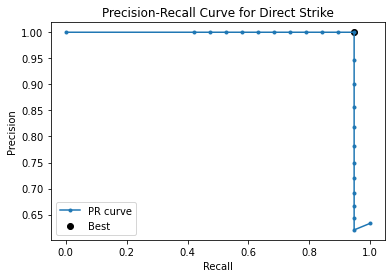

In [11]:
best_thresholds, _ = regressor_find_thresholds(lin_reg_ensembles, dev_X, dev_Y, probs_given=True, probs=dev_preds)
preds = regression_label(lin_reg_ensembles, test_X, best_thresholds, probs_given=True, probs=test_preds)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.006298
Class 1, no calibration: 0.007629
Class 2, no calibration: 0.001111
Class 3, no calibration: 0.005335


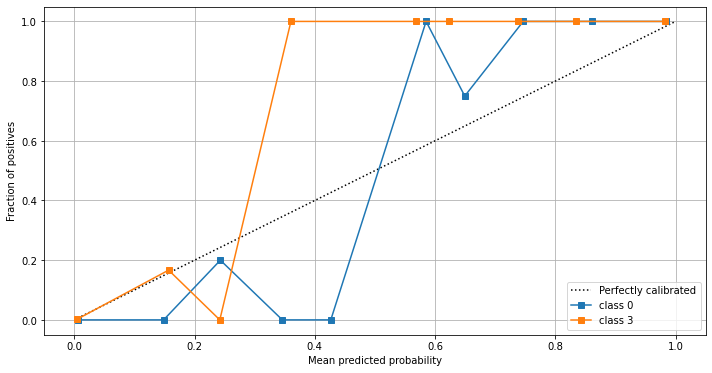

In [12]:
calibration_plot(lin_reg_ensembles, test_X, test_Y, probs_given=True, probs=test_preds)

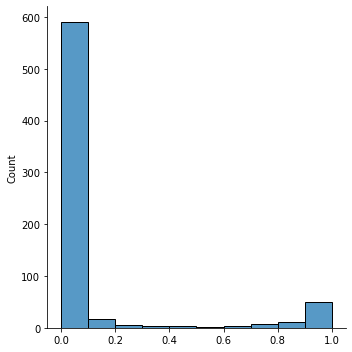

In [13]:
import seaborn as sns

sns.displot(test_preds[:,0], bins=10)

### Ensemble 2: ElasticNet Regressor
Doesn't work, period.

In [18]:
from sklearn.linear_model import ElasticNet

elastic_ensembles = []

for i in range(4):
    ensemble = ElasticNet(random_state=42).fit(all_input_preds[i, :, :], dev_Y[:,i])
    print(ensemble.coef_)
    elastic_ensembles.append(ensemble)
    
test_preds = generate_test_preds(elastic_ensembles, dataset='test')
dev_preds = generate_test_preds(elastic_ensembles, dataset='dev')

[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]


KeyboardInterrupt: 

### Ensemble 3: Extra step of Logit
Logit is a (usually) well-calibrated classifier, so out-of-bound values should not be a concern. However, the results are poorly calibrated (disappointing!). We got normal results though.

f1-score \[0.94872 0.95413 0.97143 0.84848\] average 0.93069 (still better, but the thresholds are worrying)  
thresholds \[0.12801 0.44239 0.07644 0.04481\]  
Brier loss \[0.005202 0.008392 0.002333 0.007645\]

In [14]:
from sklearn.linear_model import LogisticRegression

logit_ensembles = []

for i in range(4):
    ensemble = LogisticRegression(random_state=42).fit(all_input_preds[i, :, :], dev_Y[:,i])
    print(ensemble.coef_)
    logit_ensembles.append(ensemble)
    
test_preds = generate_test_preds(logit_ensembles, dataset='test', method='classifier')
dev_preds = generate_test_preds(logit_ensembles, dataset='dev', method='classifier')

[[3.00830379 3.3645399  1.05755632 1.50478758]]
[[2.78740906 2.81446804 1.18861295 2.53291847]]
[[2.91004608 2.41410547 1.79700034 1.72242792]]
[[2.94204149 2.28619873 1.92212513 1.65636215]]
(696, 4)
(696,)
(696, 4)
(696,)
(696, 4)
(696,)
(696, 4)
(696,)
(696, 4)
(626, 4)
(626,)
(626, 4)
(626,)
(626, 4)
(626,)
(626, 4)
(626,)
(626, 4)


Best Threshold=0.12801, F-Score=0.95161
Best Threshold=0.44239, F-Score=0.98701
Best Threshold=0.07644, F-Score=1.00000
Best Threshold=0.04481, F-Score=0.97297
              precision    recall  f1-score   support

           0    0.91358   0.98667   0.94872        75
           1    1.00000   0.91228   0.95413        57
           2    0.94444   1.00000   0.97143        17
           3    0.82353   0.87500   0.84848        16

   micro avg    0.93452   0.95152   0.94294       165
   macro avg    0.92039   0.94349   0.93069       165
weighted avg    0.93788   0.95152   0.94321       165
 samples avg    0.10884   0.10943   0.10770       165



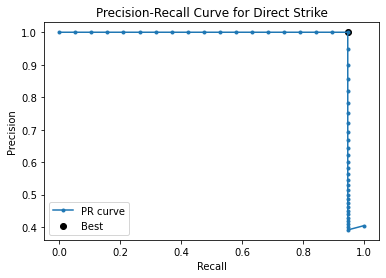

In [15]:
best_thresholds, _ = regressor_find_thresholds(logit_ensembles, dev_X, dev_Y, probs_given=True, probs=dev_preds)
preds = regression_label(logit_ensembles, test_X, best_thresholds, probs_given=True, probs=test_preds)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.005202
Class 1, no calibration: 0.008392
Class 2, no calibration: 0.002333
Class 3, no calibration: 0.007645


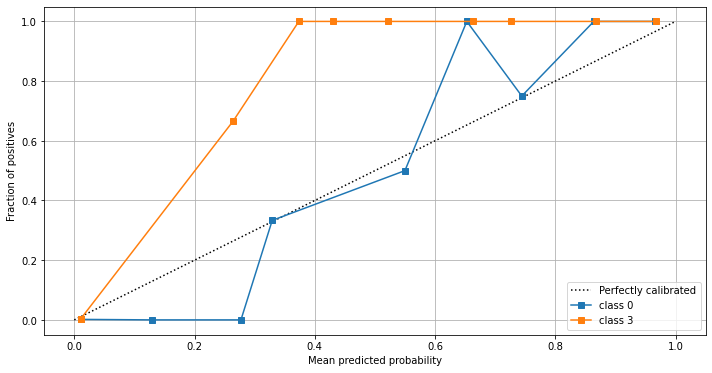

In [16]:
calibration_plot(logit_ensembles, test_X, test_Y, probs_given=True, probs=test_preds)

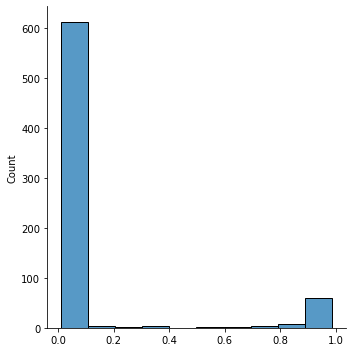

In [17]:
sns.displot(test_preds[:,0], bins=10)

### Ensemble 4: Extra Trees Classifier
Disappointment.

In [26]:
from sklearn.ensemble import ExtraTreesClassifier # redundant line ngl

extra_trees_ensembles = []

for i in range(4):
    ensemble = ExtraTreesClassifier(n_estimators=400, max_depth=5, random_state=42).fit(all_input_preds[i, :, :], dev_Y[:,i])
    print(ensemble.feature_importances_)
    extra_trees_ensembles.append(ensemble)
    
test_preds = generate_test_preds(extra_trees_ensembles, dataset='test', method='classifier')
dev_preds = generate_test_preds(extra_trees_ensembles, dataset='dev', method='classifier')

[0.37061297 0.35672612 0.06159302 0.21106789]
[0.40418398 0.24020766 0.05674492 0.29886343]
[0.43991668 0.23525582 0.10803894 0.21678855]
[0.45455182 0.2291086  0.14011925 0.17622033]
(696, 4)
(696,)
(696, 4)
(696,)
(696, 4)
(696,)
(696, 4)
(696,)
(696, 4)
(626, 4)
(626,)
(626, 4)
(626,)
(626, 4)
(626,)
(626, 4)
(626,)
(626, 4)


Best Threshold=0.57442, F-Score=0.99174
Best Threshold=0.70408, F-Score=1.00000
Best Threshold=0.90341, F-Score=1.00000
Best Threshold=0.05561, F-Score=1.00000
              precision    recall  f1-score   support

           0    0.98667   0.98667   0.98667        75
           1    1.00000   0.85965   0.92453        57
           2    1.00000   0.94118   0.96970        17
           3    0.68182   0.93750   0.78947        16

   micro avg    0.95062   0.93333   0.94190       165
   macro avg    0.91712   0.93125   0.91759       165
weighted avg    0.96309   0.93333   0.94433       165
 samples avg    0.11015   0.10776   0.10767       165



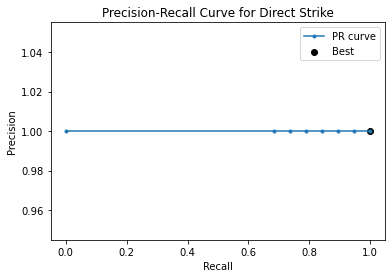

In [27]:
best_thresholds, _ = regressor_find_thresholds(extra_trees_ensembles, dev_X, dev_Y, probs_given=True, probs=dev_preds)
preds = regression_label(extra_trees_ensembles, test_X, best_thresholds, probs_given=True, probs=test_preds)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.004955
Class 1, no calibration: 0.006728
Class 2, no calibration: 0.001179
Class 3, no calibration: 0.004288


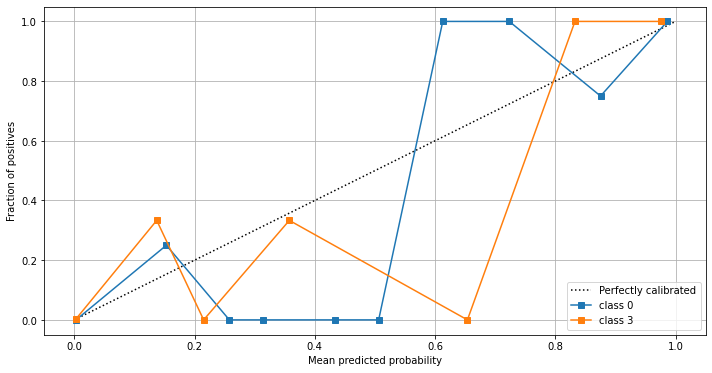

In [28]:
calibration_plot(extra_trees_ensembles, test_X, test_Y, probs_given=True, probs=test_preds)

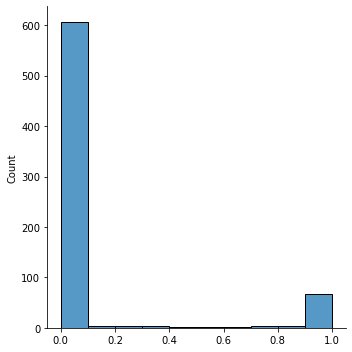

In [30]:
sns.displot(test_preds[:,0], bins=10)

### Ensemble 5: Poisson GLM
Calibration 0/10, neglected.

In [31]:
from sklearn.linear_model import PoissonRegressor

glm_ensembles = []

for i in range(4):
    ensemble = PoissonRegressor().fit(all_input_preds[i, :, :], dev_Y[:,i])
    print(ensemble.coef_)
    glm_ensembles.append(ensemble)
    
test_preds = generate_test_preds(glm_ensembles, dataset='test')
dev_preds = generate_test_preds(glm_ensembles, dataset='dev')

[0.07473769 0.07109331 0.05659551 0.06814773]
[0.05066158 0.04703534 0.03837624 0.04973946]
[0.02578905 0.02105292 0.02056882 0.02278816]
[0.02059611 0.01746387 0.01696237 0.01774879]
(696, 4)
(696,)
(696, 4)
(696,)
(696, 4)
(696,)
(696, 4)
(696,)
(696, 4)
(626, 4)
(626,)
(626, 4)
(626,)
(626, 4)
(626,)
(626, 4)
(626,)
(626, 4)


Best Threshold=0.11102, F-Score=0.94828
Best Threshold=0.06737, F-Score=0.98701
Best Threshold=0.03264, F-Score=0.97561
Best Threshold=0.03068, F-Score=0.94737
              precision    recall  f1-score   support

           0    0.98571   0.92000   0.95172        75
           1    0.96296   0.91228   0.93694        57
           2    0.80952   1.00000   0.89474        17
           3    0.82353   0.87500   0.84848        16

   micro avg    0.93827   0.92121   0.92966       165
   macro avg    0.89543   0.92682   0.90797       165
weighted avg    0.94397   0.92121   0.93073       165
 samples avg    0.10321   0.10405   0.10209       165



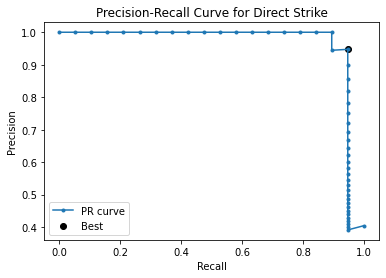

In [32]:
best_thresholds, _ = regressor_find_thresholds(glm_ensembles, dev_X, dev_Y, probs_given=True, probs=dev_preds)
preds = regression_label(glm_ensembles, test_X, best_thresholds, probs_given=True, probs=test_preds)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.091809
Class 1, no calibration: 0.074124
Class 2, no calibration: 0.023781
Class 3, no calibration: 0.022463


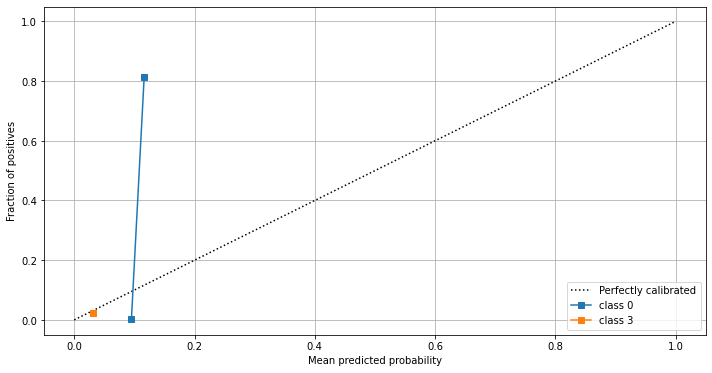

In [33]:
calibration_plot(glm_ensembles, test_X, test_Y, probs_given=True, probs=test_preds)

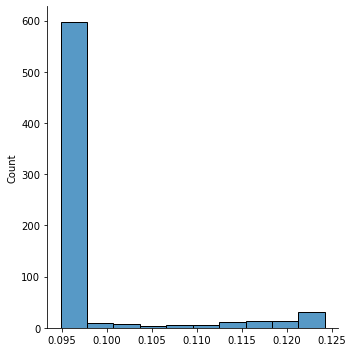

In [34]:
sns.displot(test_preds[:,0], bins=10)

### Ensemble 6: Ridge Regressor
Regularized linear regression. Slightly better than linear regressor, imo.

f1-score \[0.97368 0.94444 1.00000 0.90323\] average 0.95534  
thresholds \[43963 0.57296 0.42948 0.26073\]  
Brier loss \[0.006452 0.007645 0.001457 0.005290\]

In [18]:
from sklearn.linear_model import Ridge

ridge_ensembles = []

alpha = [1.0, 1.0, 0.875, 0.0625]

for i in range(4):
    ensemble = Ridge(alpha=alpha[i], random_state=42).fit(all_input_preds[i, :, :], dev_Y[:,i])
    print(ensemble.coef_)
    ridge_ensembles.append(ensemble)
    
test_preds = generate_test_preds(ridge_ensembles, dataset='test')
dev_preds = generate_test_preds(ridge_ensembles, dataset='dev')

[ 0.44269691  0.62597712  0.00896433 -0.00427544]
[ 0.6012321   0.25530803 -0.0045447   0.23093647]
[0.69802794 0.31608368 0.13155024 0.02457373]
[ 1.11086575 -0.05924697  0.32974699 -0.14096317]
(696, 4)
(696,)
(696, 4)
(696,)
(696, 4)
(696,)
(696, 4)
(696,)
(696, 4)
(626, 4)
(626,)
(626, 4)
(626,)
(626, 4)
(626,)
(626, 4)
(626,)
(626, 4)


Best Threshold=0.43963, F-Score=0.97521
Best Threshold=0.57296, F-Score=0.98701
Best Threshold=0.43907, F-Score=1.00000
Best Threshold=0.30441, F-Score=0.97297
              precision    recall  f1-score   support

           0    0.96104   0.98667   0.97368        75
           1    1.00000   0.89474   0.94444        57
           2    1.00000   1.00000   1.00000        17
           3    0.93333   0.87500   0.90323        16

   micro avg    0.97500   0.94545   0.96000       165
   macro avg    0.97359   0.93910   0.95534       165
weighted avg    0.97583   0.94545   0.95946       165
 samples avg    0.11063   0.10872   0.10843       165



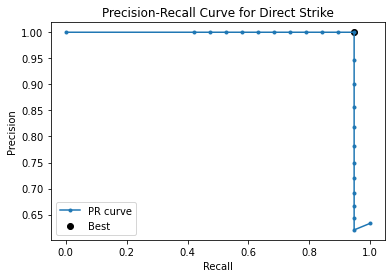

In [19]:
best_thresholds, _ = regressor_find_thresholds(ridge_ensembles, dev_X, dev_Y, probs_given=True, probs=dev_preds)
preds = regression_label(ridge_ensembles, test_X, best_thresholds, probs_given=True, probs=test_preds)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.006452
Class 1, no calibration: 0.007645
Class 2, no calibration: 0.001394
Class 3, no calibration: 0.005253


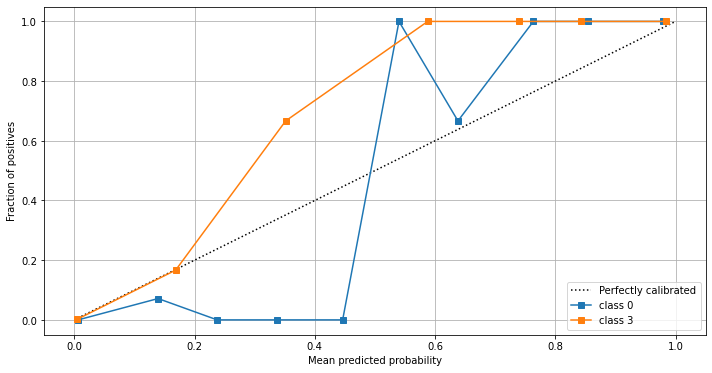

In [20]:
calibration_plot(ridge_ensembles, test_X, test_Y, probs_given=True, probs=test_preds)

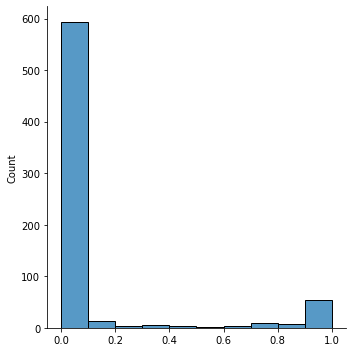

In [21]:
sns.displot(test_preds[:,0], bins=10)

In [22]:
import pickle as pk
from datetime import datetime

filename = "./models/ensemble_{0}_{1}.skl".format("4member_ridge", str(datetime.now().strftime("%Y-%m-%d %H-%M")))
with open(filename, "wb") as f:
    pk.dump(ridge_ensembles, f)

## What if we include a GAM too?
even though it is unwieldy (1.89GB size)

In [23]:
# load GAM
import pickle as pk
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, mutual_info_classif #, SelectFromModel
from functools import partial
from pygam import LinearGAM, PoissonGAM

file = open("./models/experimental_model_gam_tsnv_2022-04-14 18-20.pkl", "rb") 
gam = pk.load(file)
file.close()

In [56]:
# generate all initial predictions
all_input_preds = []

for i in range(4):
    train_preds = []

    proba = np.array(xgb_clf.predict_proba(dev_X))[i,:,1]
    train_preds.append(proba)
    proba = np.array(extra_trees_gscv_clf.predict_proba(dev_X))[i,:,1]
    train_preds.append(proba)
    train_preds.append(mlp_clf.predict_proba(dev_X)[:,i])
    proba = np.array(tsfs_calibrated_clf.predict_proba(concat_dev_X))[i,:,1]
    train_preds.append(proba)
    in_dev_X = gam["poly"][i].transform(dev_X.iloc[:,:(gam["input_feature_count"][i])])
    tr_dev_X = gam["fs"][i].transform(in_dev_X)
    preds = np.clip(gam["gam"][i].predict(tr_dev_X), 0, 1)
    train_preds.append(preds)

    train_preds = np.array(train_preds).T
    print(train_preds.shape)
    all_input_preds.append(train_preds)
    
all_input_preds = np.array(all_input_preds)
print(all_input_preds.shape)

(626, 5)
(626, 5)
(626, 5)
(626, 5)
(4, 626, 5)


In [57]:
# generate test set preds
def generate_test_preds(ensembles, dataset='test', method='clip'):

    all_test_preds = []

    for i in range(4):
        test_preds = []

        proba = np.array(xgb_clf.predict_proba(test_X if dataset=='test' else dev_X))[i,:,1]
        test_preds.append(proba)
        proba = np.array(extra_trees_gscv_clf.predict_proba(test_X if dataset=='test' else dev_X))[i,:,1]
        test_preds.append(proba)
        test_preds.append(mlp_clf.predict_proba(test_X if dataset=='test' else dev_X)[:,i])
        proba = np.array(tsfs_calibrated_clf.predict_proba(concat_test_X if dataset=='test' else concat_dev_X))[i,:,1]
        test_preds.append(proba)
        in_test_X = gam["poly"][i].transform((test_X if dataset=='test' else dev_X).iloc[:,:(gam["input_feature_count"][i])])
        tr_test_X = gam["fs"][i].transform(in_test_X)
        preds = np.clip(gam["gam"][i].predict(tr_test_X), 0, 1)
        test_preds.append(preds)
        
        test_preds = np.array(test_preds).T
        print(test_preds.shape)
        
        test_preds = ensembles[i].predict_proba(test_preds)[:,1] if method == 'classifier' else ensembles[i].predict(test_preds)
        print(test_preds.shape)
        all_test_preds.append(test_preds)
        
    all_test_preds = np.array(all_test_preds).T
    print(all_test_preds.shape)
    
    if method == 'clip':
        all_test_preds = np.clip(all_test_preds, 0, 1)
    elif method == 'sigmoid':
        all_test_preds = expit(all_test_preds)
    
    return all_test_preds

### Ridge regressor ensemble
Seems quite consistent with the previous results, which is a fancy way of saying "no improvement observed".
The calibration visibly worsened, so no.

In [77]:
from sklearn.linear_model import Ridge

ridge_ensembles = []

# alpha = [9.5, 2.5, 2.5, 3.0]
alpha=[1.0, 1.0, 1.0, 1.0]

for i in range(4):
    ensemble = Ridge(random_state=42, alpha=alpha[i]).fit(all_input_preds[i, :, :], dev_Y[:,i])
    print(ensemble.coef_)
    ridge_ensembles.append(ensemble)
    
test_preds = generate_test_preds(ridge_ensembles, dataset='test')
dev_preds = generate_test_preds(ridge_ensembles, dataset='dev')

[ 0.48971451  0.69606327  0.01640785  0.02515912 -0.19815133]
[ 0.64894987  0.30113982  0.00135621  0.27641321 -0.16829257]
[0.669322   0.31295371 0.13478824 0.04522203 0.00957084]
[0.64813922 0.23588988 0.24967196 0.08762902 0.04060676]
(696, 5)
(696,)
(696, 5)
(696,)
(696, 5)
(696,)
(696, 5)
(696,)
(696, 4)
(626, 5)
(626,)
(626, 5)
(626,)
(626, 5)
(626,)
(626, 5)
(626,)
(626, 4)


Best Threshold=0.46290, F-Score=0.97521
Best Threshold=0.35117, F-Score=1.00000
Best Threshold=0.42923, F-Score=1.00000
Best Threshold=0.26719, F-Score=0.97297
              precision    recall  f1-score   support

           0    0.96104   0.98667   0.97368        75
           1    0.93103   0.94737   0.93913        57
           2    1.00000   1.00000   1.00000        17
           3    0.93333   0.87500   0.90323        16

   micro avg    0.95210   0.96364   0.95783       165
   macro avg    0.95635   0.95226   0.95401       165
weighted avg    0.95200   0.96364   0.95763       165
 samples avg    0.10896   0.11051   0.10846       165



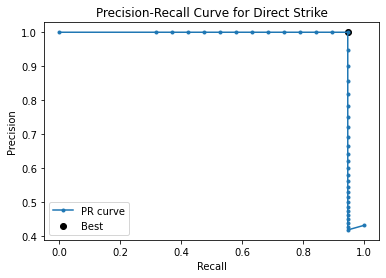

In [78]:
best_thresholds, _ = regressor_find_thresholds(ridge_ensembles, dev_X, dev_Y, probs_given=True, probs=dev_preds)
preds = regression_label(ridge_ensembles, test_X, best_thresholds, probs_given=True, probs=test_preds)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.005965
Class 1, no calibration: 0.007721
Class 2, no calibration: 0.001470
Class 3, no calibration: 0.005256


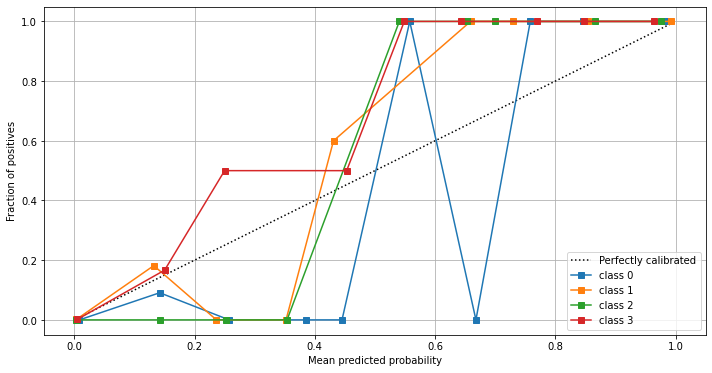

In [79]:
calibration_plot(ridge_ensembles, test_X, test_Y, probs_given=True, probs=test_preds)

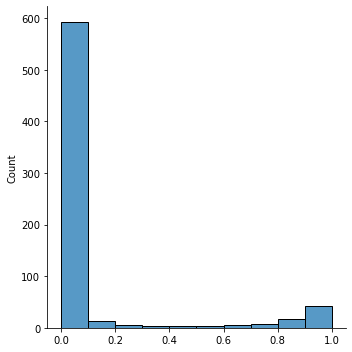

In [73]:
sns.displot(test_preds[:,0], bins=10)

### Linear regressor ensemble
Score improved somewhat but calibration still dubious.

In [31]:
from sklearn.linear_model import LinearRegression

lin_reg_ensembles = []

for i in range(4):
    ensemble = LinearRegression().fit(all_input_preds[i, :, :], dev_Y[:,i])
    print(ensemble.coef_)
    lin_reg_ensembles.append(ensemble)
    
test_preds = generate_test_preds(lin_reg_ensembles, dataset='test')
dev_preds = generate_test_preds(lin_reg_ensembles, dataset='dev')

[ 0.4287213   0.96212072 -0.00885795 -0.08166926 -0.27789371]
[ 0.92902412  0.25375643 -0.07917812  0.2280223  -0.2968426 ]
[ 1.16336258  0.30110231  0.09784909 -0.35069951 -0.07337831]
[ 1.20707643 -0.13337616  0.34853448 -0.18553576 -0.00518826]
(696, 5)
(696,)
(696, 5)
(696,)
(696, 5)
(696,)
(696, 5)
(696,)
(696, 4)
(626, 5)
(626,)
(626, 5)
(626,)
(626, 5)
(626,)
(626, 5)
(626,)
(626, 4)


Best Threshold=0.50681, F-Score=0.97521
Best Threshold=0.38006, F-Score=1.00000
Best Threshold=0.40126, F-Score=1.00000
Best Threshold=0.30976, F-Score=0.97297
              precision    recall  f1-score   support

           0    0.98667   0.98667   0.98667        75
           1    0.98148   0.92982   0.95495        57
           2    1.00000   1.00000   1.00000        17
           3    1.00000   0.87500   0.93333        16

   micro avg    0.98750   0.95758   0.97231       165
   macro avg    0.99204   0.94787   0.96874       165
weighted avg    0.98754   0.95758   0.97191       165
 samples avg    0.11207   0.10979   0.11014       165



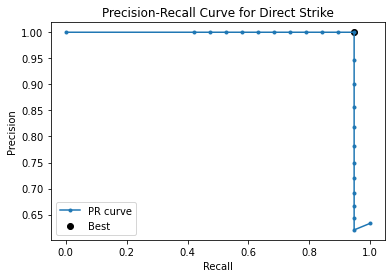

In [32]:
best_thresholds, _ = regressor_find_thresholds(lin_reg_ensembles, dev_X, dev_Y, probs_given=True, probs=dev_preds)
preds = regression_label(lin_reg_ensembles, test_X, best_thresholds, probs_given=True, probs=test_preds)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.005776
Class 1, no calibration: 0.007727
Class 2, no calibration: 0.001069
Class 3, no calibration: 0.005338


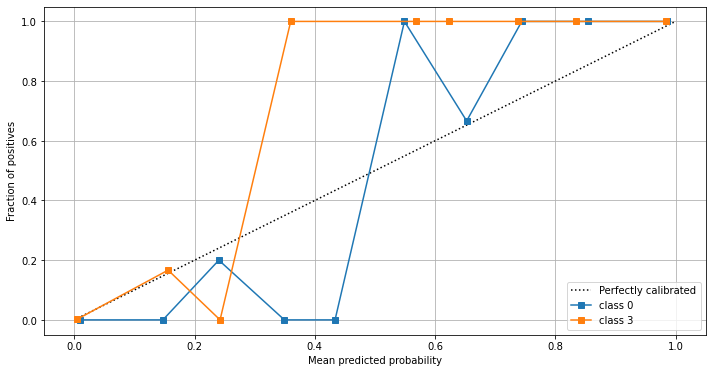

In [33]:
calibration_plot(lin_reg_ensembles, test_X, test_Y, probs_given=True, probs=test_preds)

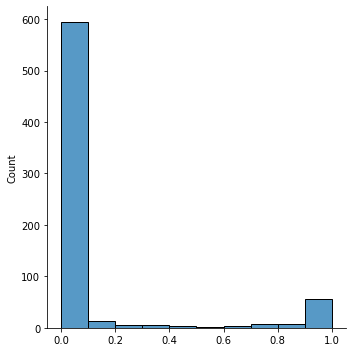

In [34]:
sns.displot(test_preds[:,0], bins=10)

In [39]:
import pickle as pk
from datetime import datetime

filename = "./models/ensemble_{0}_{1}.skl".format("5member_linreg", str(datetime.now().strftime("%Y-%m-%d %H-%M")))
with open(filename, "wb") as f:
    pk.dump(lin_reg_ensembles, f)

### Logit ensemble

In [35]:
from sklearn.linear_model import LogisticRegression

logit_ensembles = []

for i in range(4):
    ensemble = LogisticRegression(random_state=42).fit(all_input_preds[i, :, :], dev_Y[:,i])
    print(ensemble.coef_)
    logit_ensembles.append(ensemble)
    
test_preds = generate_test_preds(logit_ensembles, dataset='test', method='classifier')
dev_preds = generate_test_preds(logit_ensembles, dataset='dev', method='classifier')

[[2.85537693 3.25248249 1.00974725 1.39399911 0.73392825]]
[[2.60774678 2.62407935 1.12230936 2.34447839 1.09128934]]
[[2.69861726 2.25335991 1.61955006 1.5812624  1.40207029]]
[[2.71794475 2.07187676 1.84917212 1.53620967 1.5455376 ]]
(696, 5)
(696,)
(696, 5)
(696,)
(696, 5)
(696,)
(696, 5)
(696,)
(696, 4)
(626, 5)
(626,)
(626, 5)
(626,)
(626, 5)
(626,)
(626, 5)
(626,)
(626, 4)


Best Threshold=0.30571, F-Score=0.95082
Best Threshold=0.48420, F-Score=0.98701
Best Threshold=0.07903, F-Score=0.97561
Best Threshold=0.06005, F-Score=0.97297
              precision    recall  f1-score   support

           0    0.94872   0.98667   0.96732        75
           1    1.00000   0.89474   0.94444        57
           2    0.89474   1.00000   0.94444        17
           3    0.82353   0.87500   0.84848        16

   micro avg    0.94545   0.94545   0.94545       165
   macro avg    0.91675   0.93910   0.92617       165
weighted avg    0.94873   0.94545   0.94554       165
 samples avg    0.10884   0.10896   0.10727       165



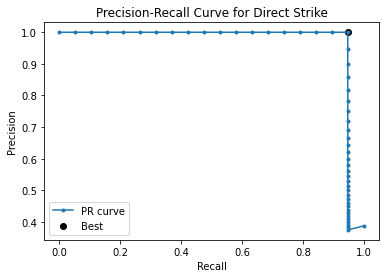

In [36]:
best_thresholds, _ = regressor_find_thresholds(logit_ensembles, dev_X, dev_Y, probs_given=True, probs=dev_preds)
preds = regression_label(logit_ensembles, test_X, best_thresholds, probs_given=True, probs=test_preds)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.005209
Class 1, no calibration: 0.008304
Class 2, no calibration: 0.002279
Class 3, no calibration: 0.007027


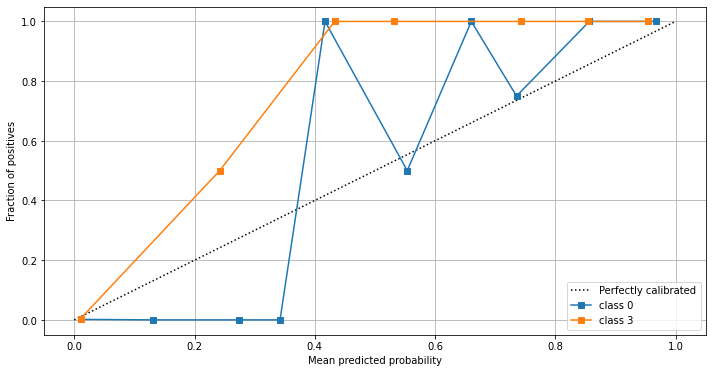

In [37]:
calibration_plot(logit_ensembles, test_X, test_Y, probs_given=True, probs=test_preds)

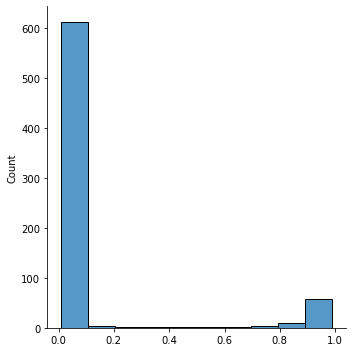

In [38]:
sns.displot(test_preds[:,0], bins=10)

## Dropped Worst Member (MLP)

In [40]:
# generate all initial predictions
all_input_preds = []

for i in range(4):
    train_preds = []

    proba = np.array(xgb_clf.predict_proba(dev_X))[i,:,1]
    train_preds.append(proba)
    proba = np.array(extra_trees_gscv_clf.predict_proba(dev_X))[i,:,1]
    train_preds.append(proba)
    proba = np.array(tsfs_calibrated_clf.predict_proba(concat_dev_X))[i,:,1]
    train_preds.append(proba)
    in_dev_X = gam["poly"][i].transform(dev_X.iloc[:,:(gam["input_feature_count"][i])])
    tr_dev_X = gam["fs"][i].transform(in_dev_X)
    preds = np.clip(gam["gam"][i].predict(tr_dev_X), 0, 1)
    train_preds.append(preds)

    train_preds = np.array(train_preds).T
    print(train_preds.shape)
    all_input_preds.append(train_preds)
    
all_input_preds = np.array(all_input_preds)
print(all_input_preds.shape)

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:50: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Ind

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:50: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:51: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_MULTIINDEX_TYPES = (

(626, 4)
(626, 4)
(626, 4)
(626, 4)
(4, 626, 4)


In [41]:
# generate test set preds
def generate_test_preds(ensembles, dataset='test', method='clip'):

    all_test_preds = []

    for i in range(4):
        test_preds = []

        proba = np.array(xgb_clf.predict_proba(test_X if dataset=='test' else dev_X))[i,:,1]
        test_preds.append(proba)
        proba = np.array(extra_trees_gscv_clf.predict_proba(test_X if dataset=='test' else dev_X))[i,:,1]
        test_preds.append(proba)
        proba = np.array(tsfs_calibrated_clf.predict_proba(concat_test_X if dataset=='test' else concat_dev_X))[i,:,1]
        test_preds.append(proba)
        in_test_X = gam["poly"][i].transform((test_X if dataset=='test' else dev_X).iloc[:,:(gam["input_feature_count"][i])])
        tr_test_X = gam["fs"][i].transform(in_test_X)
        preds = np.clip(gam["gam"][i].predict(tr_test_X), 0, 1)
        test_preds.append(preds)
        
        test_preds = np.array(test_preds).T
        print(test_preds.shape)
        
        test_preds = ensembles[i].predict_proba(test_preds)[:,1] if method == 'classifier' else ensembles[i].predict(test_preds)
        print(test_preds.shape)
        all_test_preds.append(test_preds)
        
    all_test_preds = np.array(all_test_preds).T
    print(all_test_preds.shape)
    
    if method == 'clip':
        all_test_preds = np.clip(all_test_preds, 0, 1)
    elif method == 'sigmoid':
        all_test_preds = expit(all_test_preds)
    
    return all_test_preds

### Lin Reg

In [53]:
from sklearn.linear_model import LinearRegression

lin_reg_ensembles = []

for i in range(4):
    ensemble = LinearRegression().fit(all_input_preds[i, :, :], dev_Y[:,i])
    print(ensemble.coef_)
    lin_reg_ensembles.append(ensemble)
    
test_preds = generate_test_preds(lin_reg_ensembles, dataset='test')
dev_preds = generate_test_preds(lin_reg_ensembles, dataset='dev')

[ 0.42626319  0.96131144 -0.08537226 -0.27807285]
[ 0.87962678  0.27064052  0.20036888 -0.29705041]
[ 1.19303167  0.30569219 -0.310501   -0.0613239 ]
[ 1.15672509 -0.01883855  0.07430508 -0.00965164]
(696, 4)
(696,)
(696, 4)
(696,)
(696, 4)
(696,)
(696, 4)
(696,)
(696, 4)
(626, 4)
(626,)
(626, 4)
(626,)
(626, 4)
(626,)
(626, 4)
(626,)
(626, 4)


Best Threshold=0.50520, F-Score=0.97521
Best Threshold=0.37480, F-Score=1.00000
Best Threshold=0.34359, F-Score=1.00000
Best Threshold=0.23699, F-Score=0.97297
              precision    recall  f1-score   support

           0    0.98667   0.98667   0.98667        75
           1    1.00000   0.92982   0.96364        57
           2    0.89474   1.00000   0.94444        17
           3    1.00000   0.81250   0.89655        16

   micro avg    0.98125   0.95152   0.96615       165
   macro avg    0.97035   0.93225   0.94782       165
weighted avg    0.98309   0.95152   0.96562       165
 samples avg    0.11183   0.10943   0.10993       165



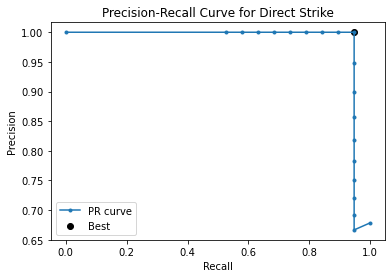

In [54]:
best_thresholds, _ = regressor_find_thresholds(lin_reg_ensembles, dev_X, dev_Y, probs_given=True, probs=dev_preds)
preds = regression_label(lin_reg_ensembles, test_X, best_thresholds, probs_given=True, probs=test_preds)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.005762
Class 1, no calibration: 0.007264
Class 2, no calibration: 0.001144
Class 3, no calibration: 0.005708


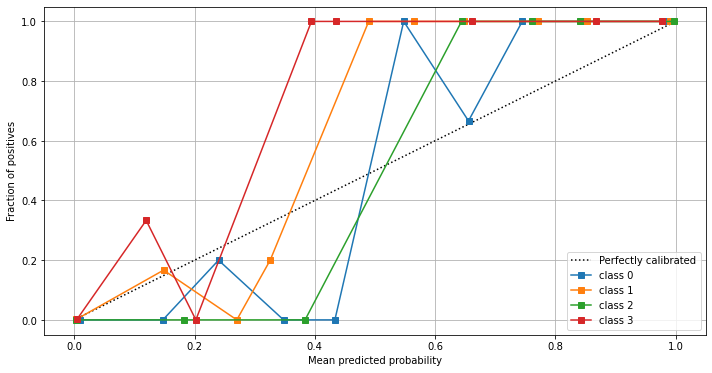

In [55]:
calibration_plot(lin_reg_ensembles, test_X, test_Y, probs_given=True, probs=test_preds)

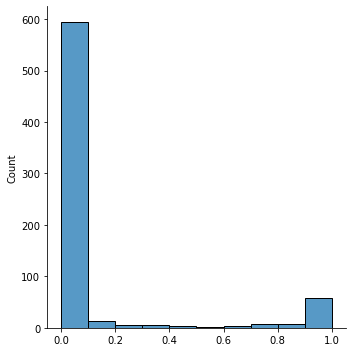

In [45]:
sns.displot(test_preds[:,0], bins=10)

In [50]:
import pickle as pk
from datetime import datetime

filename = "./models/ensemble_{0}_{1}.skl".format("nomlp_linreg", str(datetime.now().strftime("%Y-%m-%d %H-%M")))
with open(filename, "wb") as f:
    pk.dump(lin_reg_ensembles, f)

### Ridge

In [46]:
from sklearn.linear_model import Ridge

ridge_ensembles = []

for i in range(4):
    ensemble = Ridge(random_state=42).fit(all_input_preds[i, :, :], dev_Y[:,i])
    print(ensemble.coef_)
    ridge_ensembles.append(ensemble)
    
test_preds = generate_test_preds(ridge_ensembles, dataset='test')
dev_preds = generate_test_preds(ridge_ensembles, dataset='dev')

[ 0.49370645  0.6985941   0.03126806 -0.19754399]
[ 0.64956688  0.30107214  0.27684551 -0.16823206]
[0.70686279 0.33307377 0.08884348 0.02650709]
[0.6748689  0.27835054 0.22498539 0.05311038]
(696, 4)
(696,)
(696, 4)
(696,)
(696, 4)
(696,)
(696, 4)
(696,)
(696, 4)
(626, 4)
(626,)
(626, 4)
(626,)
(626, 4)
(626,)
(626, 4)
(626,)
(626, 4)


Best Threshold=0.46596, F-Score=0.97521
Best Threshold=0.35133, F-Score=1.00000
Best Threshold=0.37098, F-Score=1.00000
Best Threshold=0.29124, F-Score=0.97297
              precision    recall  f1-score   support

           0    0.96104   0.98667   0.97368        75
           1    0.93103   0.94737   0.93913        57
           2    1.00000   1.00000   1.00000        17
           3    1.00000   0.81250   0.89655        16

   micro avg    0.95758   0.95758   0.95758       165
   macro avg    0.97302   0.93663   0.95234       165
weighted avg    0.95847   0.95758   0.95698       165
 samples avg    0.10920   0.11015   0.10850       165



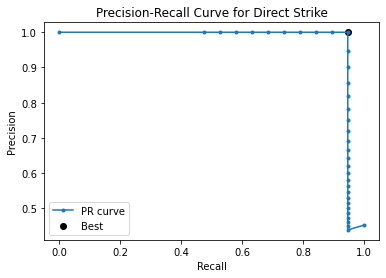

In [47]:
best_thresholds, _ = regressor_find_thresholds(ridge_ensembles, dev_X, dev_Y, probs_given=True, probs=dev_preds)
preds = regression_label(ridge_ensembles, test_X, best_thresholds, probs_given=True, probs=test_preds)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.005992
Class 1, no calibration: 0.007728
Class 2, no calibration: 0.001526
Class 3, no calibration: 0.005642


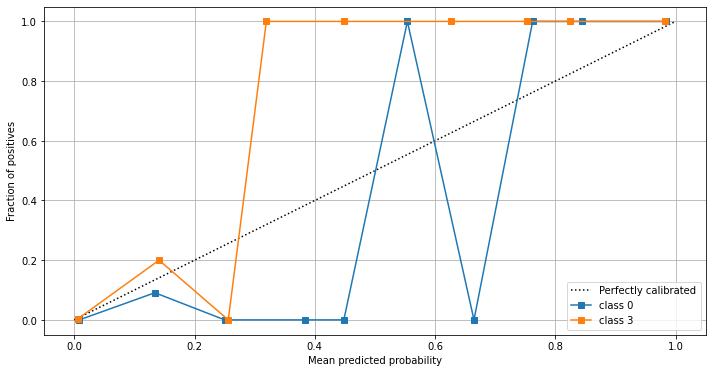

In [48]:
calibration_plot(ridge_ensembles, test_X, test_Y, probs_given=True, probs=test_preds)

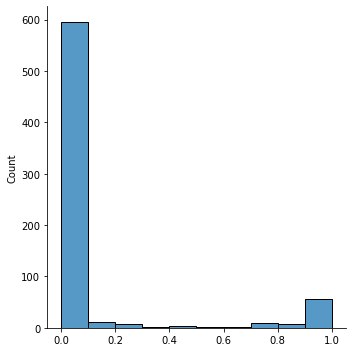

In [49]:
sns.displot(test_preds[:,0], bins=10)

## (For Fun Only) Even more members!

Members roster:
- XGBoost classifier
- XGBoost regressor
- Extra Trees classifier
- Extra Trees regressor
- MLP classifier
- Time series forest classifier (calibrated)
- GAM

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sklearn.neural_network import MLPClassifier
import pickle as pk
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, mutual_info_classif #, SelectFromModel
from functools import partial
from pygam import LinearGAM, PoissonGAM

xgb_clf = joblib.load("./models/experimental_model_gscv_xgb_clf_2022-04-12 19-13.skl")
xgb_regr = joblib.load("./models/experimental_model_gscv_xgb_regr_2022-04-16 20-15.skl")
extra_trees_gscv_clf = joblib.load("./models/experimental_model_gscv_extra_trees_clf_2022-04-12 19-18.skl")
extra_trees_gscv_regr = joblib.load("./models/experimental_model_gscv_extra_trees_regr_2022-04-16 17-15.skl")
mlp_clf = joblib.load("./models/experimental_model_mlpclf_2022-04-12 21-18.skl")
tsfs_calibrated_clf = joblib.load("./models/experimental_model_calibrated_gscv_tsfs_clf_2022-04-12 20-11.skl")

file = open("./models/experimental_model_gam_tsnv_2022-04-14 18-20.pkl", "rb") 
gam = pk.load(file)
file.close()

warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
# generate all initial predictions
all_input_preds = []

for i in range(4):
    train_preds = []

    proba = np.array(xgb_clf.predict_proba(dev_X))[i,:,1]
    train_preds.append(proba)
    proba = np.array(xgb_regr.predict(dev_X))[:,i]
    train_preds.append(proba)
    
    proba = np.array(extra_trees_gscv_clf.predict_proba(dev_X))[i,:,1]
    train_preds.append(proba)
    proba = np.array(extra_trees_gscv_regr.predict(dev_X))[:,i]
    train_preds.append(proba)
    
    train_preds.append(mlp_clf.predict_proba(dev_X)[:,i])
    
    proba = np.array(tsfs_calibrated_clf.predict_proba(concat_dev_X))[i,:,1]
    train_preds.append(proba)
    
    in_dev_X = gam["poly"][i].transform(dev_X.iloc[:,:(gam["input_feature_count"][i])])
    tr_dev_X = gam["fs"][i].transform(in_dev_X)
    preds = np.clip(gam["gam"][i].predict(tr_dev_X), 0, 1)
    train_preds.append(preds)

    train_preds = np.array(train_preds).T
    print(train_preds.shape)
    all_input_preds.append(train_preds)
    
all_input_preds = np.array(all_input_preds)
print(all_input_preds.shape)

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is depre

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd

(626, 7)


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: Fu

(626, 7)


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprec

(626, 7)


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgb

(626, 7)
(4, 626, 7)


In [9]:
# generate test set preds
def generate_test_preds(ensembles, dataset='test', method='clip'):

    all_test_preds = []

    for i in range(4):
        test_preds = []

        proba = np.array(xgb_clf.predict_proba(test_X if dataset=='test' else dev_X))[i,:,1]
        test_preds.append(proba)
        proba = np.array(xgb_regr.predict(test_X if dataset=='test' else dev_X))[:,i]
        test_preds.append(proba)
        
        proba = np.array(extra_trees_gscv_clf.predict_proba(test_X if dataset=='test' else dev_X))[i,:,1]
        test_preds.append(proba)
        proba = np.array(extra_trees_gscv_regr.predict(test_X if dataset=='test' else dev_X))[:,i]
        test_preds.append(proba)
        
        test_preds.append(mlp_clf.predict_proba(test_X if dataset=='test' else dev_X)[:,i])
        
        proba = np.array(tsfs_calibrated_clf.predict_proba(concat_test_X if dataset=='test' else concat_dev_X))[i,:,1]
        test_preds.append(proba)
        
        in_test_X = gam["poly"][i].transform((test_X if dataset=='test' else dev_X).iloc[:,:(gam["input_feature_count"][i])])
        tr_test_X = gam["fs"][i].transform(in_test_X)
        preds = np.clip(gam["gam"][i].predict(tr_test_X), 0, 1)
        test_preds.append(preds)
        
        test_preds = np.array(test_preds).T
        print(test_preds.shape)
        
        test_preds = ensembles[i].predict_proba(test_preds)[:,1] if method == 'classifier' else ensembles[i].predict(test_preds)
        print(test_preds.shape)
        all_test_preds.append(test_preds)
        
    all_test_preds = np.array(all_test_preds).T
    print(all_test_preds.shape)
    
    if method == 'clip':
        all_test_preds = np.clip(all_test_preds, 0, 1)
    elif method == 'sigmoid':
        all_test_preds = expit(all_test_preds)
    
    return all_test_preds

### Lin Reg

In [10]:
from sklearn.linear_model import LinearRegression

lin_reg_ensembles = []

for i in range(4):
    ensemble = LinearRegression().fit(all_input_preds[i, :, :], dev_Y[:,i])
    print(ensemble.coef_)
    lin_reg_ensembles.append(ensemble)
    
test_preds = generate_test_preds(lin_reg_ensembles, dataset='test')
dev_preds = generate_test_preds(lin_reg_ensembles, dataset='dev')

[ 0.43640846 -0.0229788   1.13326882 -0.17304804 -0.00485649 -0.07936797
 -0.2690231 ]
[ 0.94168882 -0.05445153  0.23986987  0.04091915 -0.07729949  0.23705885
 -0.29533991]
[ 1.29047718 -0.21989786 -0.44548749  0.87761234  0.05521804 -0.34404177
 -0.07163516]
[ 1.0498926   0.45577866 -0.06452758 -0.27157669  0.32542914 -0.18723799
 -0.02008268]


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgb

(696, 7)
(696,)


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgb

(696, 7)
(696,)


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgb

(696, 7)
(696,)


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgb

(696, 7)
(696,)
(696, 4)


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgb

(626, 7)
(626,)


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgb

(626, 7)
(626,)


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgb

(626, 7)
(626,)


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgb

(626, 7)
(626,)
(626, 4)


Best Threshold=0.50461, F-Score=0.97521
Best Threshold=0.36904, F-Score=1.00000
Best Threshold=0.41218, F-Score=1.00000
Best Threshold=0.33562, F-Score=0.97297
              precision    recall  f1-score   support

           0    0.98667   0.98667   0.98667        75
           1    0.98148   0.92982   0.95495        57
           2    1.00000   1.00000   1.00000        17
           3    1.00000   0.87500   0.93333        16

   micro avg    0.98750   0.95758   0.97231       165
   macro avg    0.99204   0.94787   0.96874       165
weighted avg    0.98754   0.95758   0.97191       165
 samples avg    0.11207   0.10979   0.11014       165



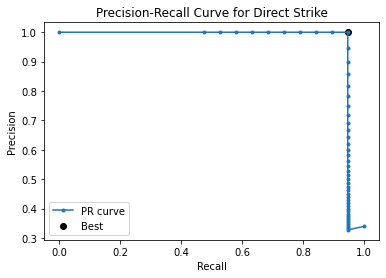

In [11]:
best_thresholds, _ = regressor_find_thresholds(lin_reg_ensembles, dev_X, dev_Y, probs_given=True, probs=dev_preds)
preds = regression_label(lin_reg_ensembles, test_X, best_thresholds, probs_given=True, probs=test_preds)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.005721
Class 1, no calibration: 0.007695
Class 2, no calibration: 0.001237
Class 3, no calibration: 0.005182


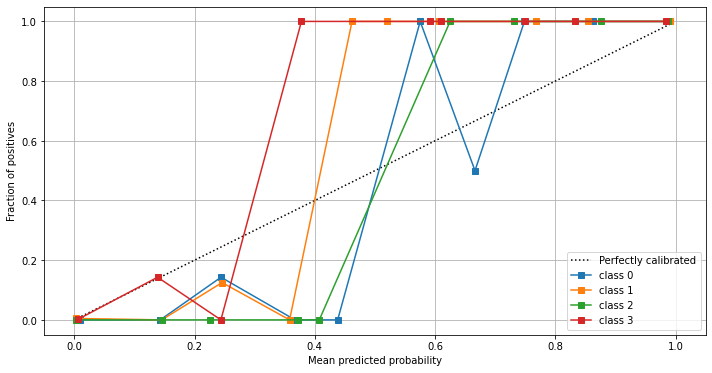

In [12]:
calibration_plot(lin_reg_ensembles, test_X, test_Y, probs_given=True, probs=test_preds)

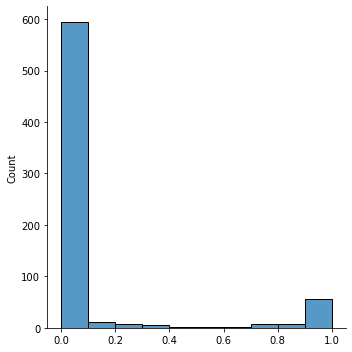

In [13]:
import seaborn as sns

sns.displot(test_preds[:,0], bins=10)

### Ridge

In [85]:
from sklearn.linear_model import Ridge

ridge_ensembles = []
#alpha = [3.5, 2.5, 3.5, 3.0]
alpha = [1.0, 1.0, 1.0, 1.0]

for i in range(4):
    ensemble = Ridge(random_state=42, alpha=alpha[i]).fit(all_input_preds[i, :, :], dev_Y[:,i])
    print(ensemble.coef_)
    ridge_ensembles.append(ensemble)
    
test_preds = generate_test_preds(ridge_ensembles, dataset='test')
dev_preds = generate_test_preds(ridge_ensembles, dataset='dev')

[ 0.41484942  0.05520343  0.47995985  0.31820385  0.00305671 -0.00720097
 -0.22851333]
[ 0.6158437   0.05625275  0.17679029  0.15976756 -0.00277245  0.24191267
 -0.18093644]
[ 0.64609792  0.0050453   0.20203121  0.20316766  0.12333716  0.01942851
 -0.00866192]
[ 0.53275193  0.30968316  0.10118313  0.088564    0.22204093  0.06317234
 -0.00406132]


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgb

(696, 7)
(696,)


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgb

(696, 7)
(696,)


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgb

(696, 7)
(696,)


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgb

(696, 7)
(696,)
(696, 4)


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgb

(626, 7)
(626,)


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgb

(626, 7)
(626,)


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgb

(626, 7)
(626,)


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgb

(626, 7)
(626,)
(626, 4)


Best Threshold=0.40494, F-Score=0.97521
Best Threshold=0.37428, F-Score=1.00000
Best Threshold=0.39512, F-Score=1.00000
Best Threshold=0.27891, F-Score=0.97297
              precision    recall  f1-score   support

           0    0.96104   0.98667   0.97368        75
           1    0.93103   0.94737   0.93913        57
           2    0.94444   1.00000   0.97143        17
           3    0.92857   0.81250   0.86667        16

   micro avg    0.94611   0.95758   0.95181       165
   macro avg    0.94127   0.93663   0.93773       165
weighted avg    0.94582   0.95758   0.95114       165
 samples avg    0.10884   0.11015   0.10811       165



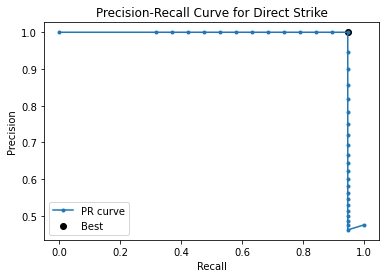

In [79]:
best_thresholds, _ = regressor_find_thresholds(ridge_ensembles, dev_X, dev_Y, probs_given=True, probs=dev_preds)
preds = regression_label(ridge_ensembles, test_X, best_thresholds, probs_given=True, probs=test_preds)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.006775
Class 1, no calibration: 0.007868
Class 2, no calibration: 0.002460
Class 3, no calibration: 0.005356


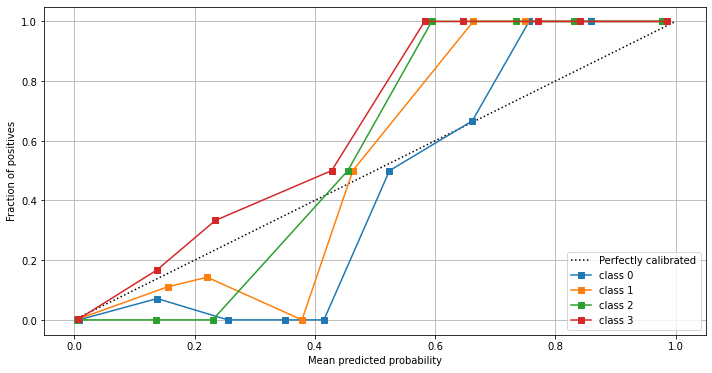

In [80]:
calibration_plot(ridge_ensembles, test_X, test_Y, probs_given=True, probs=test_preds)

Best Threshold=0.46881, F-Score=0.97521
Best Threshold=0.37784, F-Score=1.00000
Best Threshold=0.46717, F-Score=1.00000
Best Threshold=0.29701, F-Score=0.97297
              precision    recall  f1-score   support

           0  0.98305085 0.95081967 0.96666667        61
           1  1.00000000 0.97435897 0.98701299        39
           2  1.00000000 0.95000000 0.97435897        20
           3  1.00000000 0.89473684 0.94444444        19

   micro avg  0.99248120 0.94964029 0.97058824       139
   macro avg  0.99576271 0.94247887 0.96812077       139
weighted avg  0.99256188 0.94964029 0.97044458       139
 samples avg  0.09864217 0.09704473 0.09752016       139

[[0.01965738 0.         0.         0.00441432]
 [0.01878195 0.         0.         0.00264044]
 [0.         0.         0.         0.00109676]
 ...
 [0.00792273 0.         0.         0.        ]
 [0.04405191 0.00196225 0.00071665 0.        ]
 [0.00566497 0.         0.         0.00011283]]


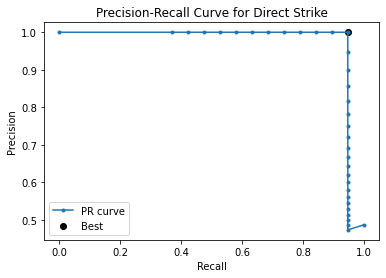

In [86]:
best_thresholds, _ = regressor_find_thresholds(ridge_ensembles, dev_X, dev_Y, probs_given=True, probs=dev_preds)
preds = regression_label(ridge_ensembles, dev_X, best_thresholds, probs_given=True, probs=dev_preds)
print(classification_report(dev_Y, preds, zero_division=0, digits=8))
print(dev_preds)

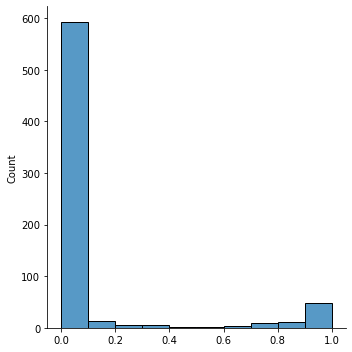

In [84]:
sns.displot(test_preds[:,0], bins=10)

In [83]:
import pickle as pk
from datetime import datetime

filename = "./models/ensemble_{0}_{1}.skl".format("7member_ridge", str(datetime.now().strftime("%Y-%m-%d %H-%M")))
with open(filename, "wb") as f:
    pk.dump(ridge_ensembles, f)